## Ансамбли (продолжение)
Пензин М.С.

penzin.ml.tsu@gmail.com

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

## Голосование

* Простое голосование 
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \frac{1}{M} \sum_{m=1}^M f_m(\vec{x})
$$

* Взвешенное голосование
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \sum_{m=1}^M \omega_m f_m(\vec{x})
$$

* Смесь
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \sum_{m=1}^M g_m(\vec{x}) f_m(\vec{x})
$$

## Взвешенное голосование

для регрессии

$$
R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \sum_{m=1}^{M} \omega_m f_m(\vec{x})
$$

для бинарной классификации с классами $y = \{-1, +1\}$ 

$$
R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \mathrm{sign} \left[ \sum_{m=1}^{M} \omega_m f_m(\vec{x}) \right]
$$

Мы уже рассматривали вариант, когда у нас модели обучались заранее, а потом на основе уже обученных моделей мы искали коэффициенты взвешенного голосования.

А что если мы не будет обучать модели заранее, а будем определять параметры нашей модели наравне с весами?

$$
R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \mathrm{sign} \left[ \sum_{m=1}^{M} \omega_m f_m(\vec{x}) \right]
$$

## Основная идея

Будем рассматривать задачу бинарной классификации, где $y = \{-1, +1\}$.

Для упрощения нахождение оптимальной комбинации моделей, мы будет искать их итеративно, добавляя модели по одной (жадный алгоритм).

$$
R_m = \sum_{i=1}^{m} \alpha_i f_i(\vec{x}) = R_{m-1} + \alpha_m f_m(\vec{x})
$$

Теперь нам нужно найти самые оптимальные $\alpha_m$ и $f_m$ минимизируя функционал качества $Q_m$, который просто является количеством неправильных ответов. Для классификации - это сумма "ступенек".

$$
Q_m = \sum_n \left[  \mathrm{sign} \left(R_m(\vec{x}_n)\right) \ne y_n \right]
$$

Для упрощения задачи, мы приближаем одну ступеньку непрерывно дифференцируемой оценкой сверху.

Если взять в качестве оценки 

$$
L(f, \vec{x}, y) = \exp(-y f(\vec{x}))
$$

то просто получим **AdaBoost**

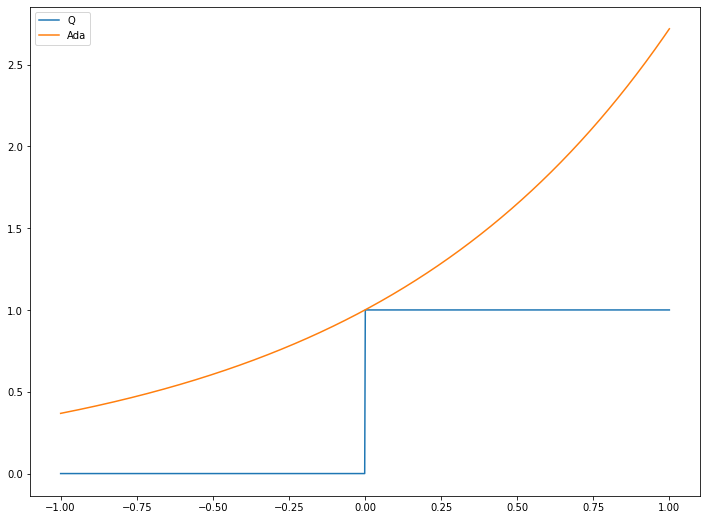

In [12]:
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.heaviside(x, 0.5), label="Q"); plt.plot(x, np.exp(x), label="Ada");plt.legend();

## AdaBoost

__[Adaptive Boosting](https://mbernste.github.io/files/notes/AdaBoost.pdf)__ - один из первых и простейших алгоритмов бустинга.

* Пусть есть набор объектов $\mathrm{X}$ размером $N$ и набор меток класса $\mathrm{Y}$.
* Инициализируем вектор весов наших объектов $\omega_1(n) = \frac{1}{N}, i = 1, \dotsc, N$

Для каждого шага

1. Находим классификатор, который минимизирует взвешенную ошибку классификации
$$
    \varepsilon_m = \sum_n \omega_m(n) [y_n \ne f_m(\vec{x}_n)]
$$

2. Выбираем $\alpha_m$
$$
    \alpha_m = \frac{1}{2} \ln \frac{1 - \varepsilon_m}{\varepsilon_m}
$$

3. Обновляем веса
$$
    \omega_{m+1}(n) = \frac{\omega_m(n) \exp(-\alpha_m y_n f_m(\vec{x}_n))}{\Omega_m}
$$

где $\Omega_m$ - это константа нормализация, такая что $\sum\omega(n) = 1$

Результирующий классификатор

$$
R(\vec{x}) = \mathrm{sign} \sum_m \alpha_m f_m(\vec{x})
$$

Как же это работает?

In [13]:
data = np.array([
    (1, 9, 1), (1, 3, 1),    
    (2, 5, 1), (2, 7, -1),    
    (3, 4, 1), (3, 9, -1),    
    (4, 2, 1), 
    (5, 5, 1), (5, 7, -1),
    (6, 1, -1), (7, 3, -1),
])

X, Y = data[:, :2], data[:, 2]
w = np.ones(X.shape[0]) / X.shape[0]

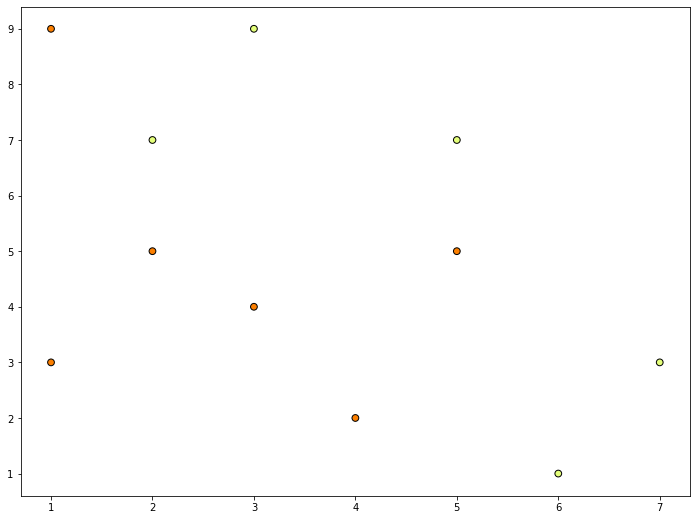

In [14]:
plt.scatter(X[:, 0], X[:, 1], s=w*500, c=Y, cmap="Wistia", edgecolor="k");

In [15]:
def plot(clf, X, Y, w):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    dx = (x_max - x_min) * 0.1
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    dy = (y_max - y_min) * 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min - dx, x_max + dx, 100),
                        np.linspace(y_min - dy, y_max + dy, 100))
    
    Z = clf.predict(np.stack([xx.ravel(), yy.ravel()], axis=1))
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap="Wistia")
    plt.scatter(X[:, 0], X[:, 1], s=w*500, c=Y, 
                cmap="Wistia", edgecolors='k')    
    plt.show()

In [16]:
clfs = []
alphas = []
weights = [w, ]

In [17]:
class DecisionStump:
    """
        Примитивная реализация решающего пенька
    """ 
    def __init__(self):
        self._feature_index = None
        self._feature_value = None
        self._target_true = None
        self._target_false = None
        
    def fit(self, X, y, sample_weight):
        """
            Просто честно проходим по всем доступным значениям
        """
        
        n_features = X.shape[1]
        
        min_err = None
        
        for idx_f in range(n_features):
            # Отбираем все уникальные значения и ставим разделитель между ними
            feature = X[:, idx_f]
            uniq = np.sort(np.unique(feature))
            values = []
            for i in range(len(uniq) - 1):
                values.append((uniq[i+1] + uniq[i]) * 0.5)
 
            for v in values:
                mask_true = feature < v
                mask_false = feature > v
                
                y_true = 1 if y[mask_true].sum() >= 0 else -1
                y_false = 1 if y[mask_false].sum() >= 0 else -1
                
                
                err = 0
                err += ((y[mask_true] != y_true) * sample_weight[mask_true]).sum() 
                err += ((y[mask_false] != y_false) * sample_weight[mask_false]).sum()
                
                if min_err is None or min_err > err:
                    self._feature_value = v
                    self._feature_index = idx_f
                    self._target_true = y_true
                    self._target_false = y_false
                    
                    min_err = err
                    
    def predict(self, X):
        result = np.zeros(X.shape[0])
        
        feature = X[:, self._feature_index]

        result[ feature <= self._feature_value ] = self._target_true
        result[ feature > self._feature_value ] = self._target_false
        
        return result
    

In [18]:
def ada_step(X, Y, w):
    # будем делать через пеньки
    clf = DecisionStump()
    clf.fit(X, Y, sample_weight=w)

    pred = clf.predict(X)
    eps = (w * (pred != Y)).sum()
    alpha = 0.5 * np.log( (1 - eps) / eps )
    
    w = w * np.exp(-alpha * Y * pred)
    w = w / w.sum()
    
    return clf, alpha, w

In [19]:
# Делаем несколько итераций AdaBoost

for _ in range(10):
    clf, alpha, w = ada_step(X, Y, w)
    clfs.append(clf); alphas.append(alpha); weights.append(w)

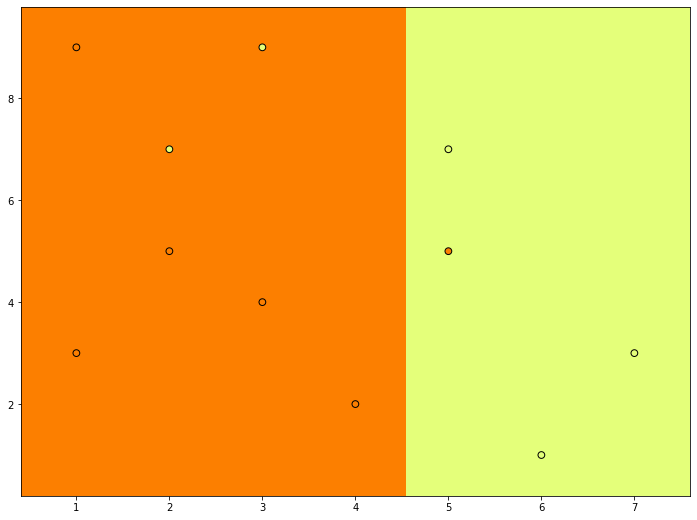

In [20]:
plot(clfs[0], X, Y, weights[0])

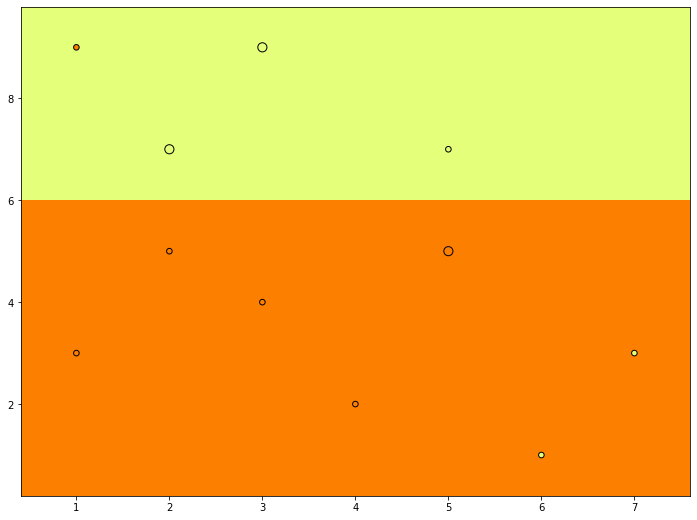

In [21]:
plot(clfs[1], X, Y, weights[1])

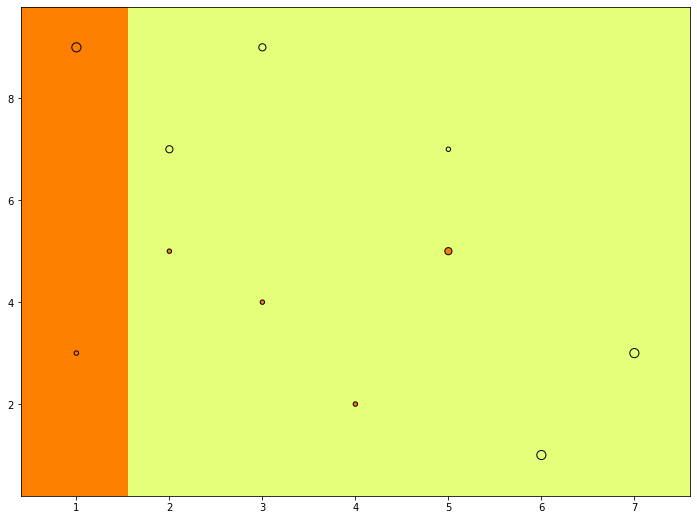

In [22]:
plot(clfs[2], X, Y, weights[2])

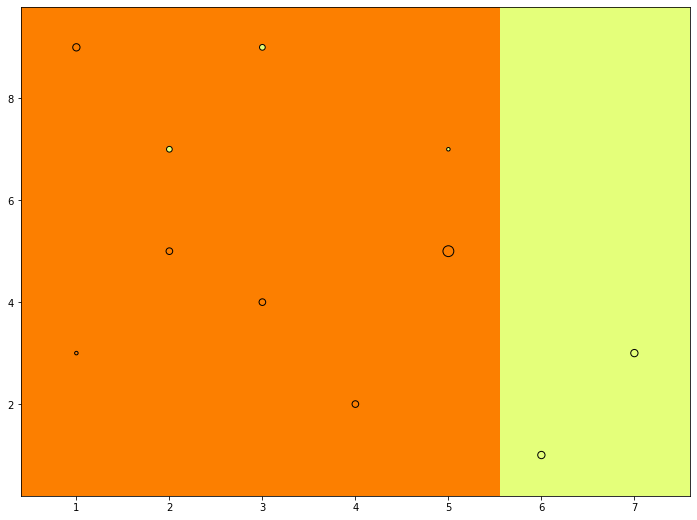

In [23]:
plot(clfs[3], X, Y, weights[3])

In [24]:
class AdaClassifier:
    def __init__(self, alphas, clfs):
        self.alphas = alphas
        self.clfs = clfs

    def predict(self, X):
        vote = np.zeros(X.shape[0])
        
        for a, clf in zip(self.alphas, self.clfs):
            vote += a * clf.predict(X)            
        return np.sign(vote)

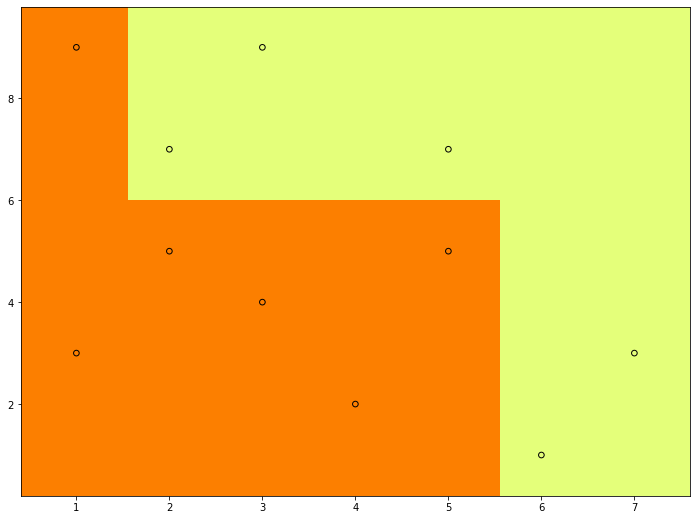

In [25]:
plot(AdaClassifier(alphas, clfs), X, Y, w[0])

## А что если?

Не все методы поддерживают обучение со взвешенными данным, в этом случае, вектор весов $\omega_m$ можно трактовать как вероятность достать данный объект при формировании бутстрап-выборки для обучения следующего классификатора.

## sklearn

В библиотеке **sklearn** уже реализован данный алгоритм и он представлен двумя классам: __AdaBoostClassifier__ и **AdaBoostRegressor**. 

Их основными гиперпараметрами являются: класс слабой модели и количество моделей.

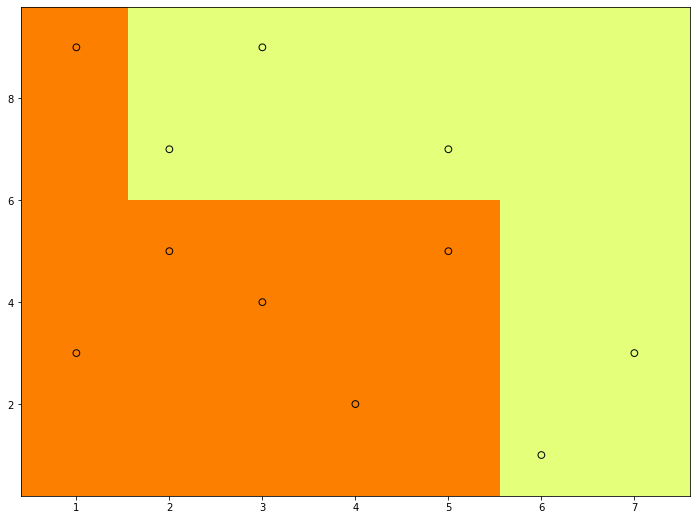

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 3)
ada.fit(X, Y)
plot(ada, X, Y, weights[0])

## Плюсы AdaBoost

* данный алгоритм очень прост для реализации
* эффективен с точки зрения вычислительной сложности
* позволяет решать достаточно сложные задачи с помощью слабых моделей
* фактически только два параметра настройки: класс моделей и их количество
* обеспечивает высокую точность прогнозирования
* прост для модификации

## Минусы AdaBoost

* использование сложных или сильных моделей приводит к переобучению
* чувствительность к выбросам (им достаются самые высокие значения весов), что приводит к переобучению
* практически не поддается интерпретации
* желательно иметь достаточно большую выборку, иначе может привести к переобучению

## Градиентный бустинг

__[Gradient Boosting Machine (GBM)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)__ - обобщенный и стандартизированный подход. 

Пусть у нас есть набор объектов $\mathbf{X}$ и набор целевых исходов $\vec{y}$, для которых мы будем восстанавливать зависимость в виде $y = f(\vec{x})$.

Для того, чтобы понять какое из наших приближений $\bar{f}$ лучше, мы будет его выбирать так, чтобы минимизировать функционал потерь

$$
\bar{f} = \arg\min_{f} \sum_n L(y_n, f(\vec{x}_n))
$$

Искать решение итогового классификатора будем в виде

$$
R(\vec{x}) = \sum_m \alpha_m f_m(\vec{x})
$$

при этом искать $(\alpha_m, f_m)$ мы будем итеративно, по одному, каждый раз решая задачу

$$
(\alpha_m, f_m) = \arg\min_{\alpha, f} \sum_n L(y_n, R_{m-1}(\vec{x}_n) + \alpha f(\vec{x}_n))
$$

$$
(\alpha_m, f_m) = \arg\min_{\alpha, f} \sum_n L(y_n, R_{m-1}(\vec{x}_n) + \alpha f(\vec{x}_n))
$$

Самый простой вариант: мы можем выбрать конкретную функцию потерь и с ней работать.

Если взять квадратичную ошибку (L2boosting)

$$
L = \frac{1}{2} (y - f(\vec{x}))^2
$$

$$
(\alpha_m, f_m) = \arg\min_{\alpha, f} \sum_n (y_n - R_{m-1}(\vec{x}_n) - \alpha f(\vec{x}_n))^2
$$

$$
(\alpha_m, f_m) = \arg\min_{\alpha, f} \sum_n (r_{nm} - \alpha f(\vec{x}_n))^2\\
r_{nm} = y_n - R_{m-1}(\vec{x}_n)
$$

Стало намного легче искать, но что если нам теперь хочется сменить функцию потерь?

Попробуем теперь обобщить. Будем искать нашу модель, минимизируя 

$$
\bar{R} = \arg\min_R \sum_n L(y_n, R(\vec{x}_n))
$$

Тут если очень присмотреться к записи 

$$
R(\vec{x}) = \sum_m \alpha_m f_m(\vec{x})
$$

то можно заметить, что это что-то вроде перемещения от точки к точке в функциональном пространстве. Нечто похожее мы можем видеть, когда ищем минимум функционала с помощью обратного градиента.

В обычном пространстве минимизировать мы уже умеем, но что нам мешает сделать тоже самое в функциональном?

$$
g_{nm} = \left[
\frac{
    \partial L(y_n, f(\vec{x}_n))
}{
    \partial f(\vec{x}_n)
}
\right]_{f = R_{m-1}}
$$

Отсюда новый набор наших "параметров"

$$
g_{nm} = \left[
\frac{
    \partial L(y_n, f(\vec{x}_n))
}{
    \partial f(\vec{x}_n)
}
\right]_{f = R_{m-1}}
\\
R_m(\vec{x}_n) = R_{m-1}(\vec{x}_n) - \alpha_m g_{nm} 
\\
\alpha_m = \arg\min_\alpha \sum_n L(R_{m-1}(\vec{x}_n) - \alpha g_{nm})
$$

И это нам не очень помогает, т.к. это оптимизирует какую-то абстрактную функцию $R$ зависящую от неизвестной нам функции $f$.

Однако, мы можем потребовать, чтобы слабая модель апроксимировала антиградиент

$$
\theta_m = \arg\min_\theta \sum_n (-g_{nm} - f_m(\vec{x}_n, \theta))^2
$$

при этом не обязательно использовать минимизацию квадратичной ошибки.

Теперь мы готовы описать обобщенный  алгоритм

$$
r_{nm} = -g_{nm} = - \left.\frac{\partial L(y_n, f(\vec{x}_n))}{\partial f(\vec{x}_n)}\right|_{f = R_{m-1}}
\\
\theta_m = \arg\min \sum_n (r_{nm} - f_m(\vec{x}_i, \theta))^2
\\
\alpha_m = \arg\min \sum_n L(y_n, R_{m-1}(\vec{x}_i) + \alpha f_m(\vec{x}_i, \theta_m))
$$

* Пусть есть набор объектов $\mathbf{X}$ размером $N$ и набор меток класса $\vec{y}$.
* Первой моделью выбираем константный прогноз

$$
f_0(\vec{x}) = \arg\min_{\alpha_0} \sum_n L(\alpha_0, y_n)
$$

Для каждого шага

1. Вычисляем остатки предыдущей композиции $r_{nm}$
2. Обучаем базовую модель $f_m(\vec{x})$ на остатках $r_{nm}$
3. Вычисляем $\alpha_m$ как решение простой оптимизационной задачи
4. Добавить новый классификатор в ансамбль $R_m = R_{m-1} + \alpha_m f_m$

Итоговая модель
$$
R(\vec{x}) = \alpha_0 + \sum_{m=1}^{M} \alpha_m f_m(\vec{x})
$$

## Регрессия

* квадрат ошибки($L_2$ loss)
$$ L(y, f) = \frac{1}{2} (y - f)^2$$
* абсолютная ошибка($L_1$ loss) 
$$L(y, f) = |y - f|$$

* Huber loss 

$$
L(y, f) = \left\{
\begin{eqnarray}
&\frac{1}{2}(y - f)^2, &|y - f| \le \delta 
\\
&\delta\left(|y-f| - \frac{\delta}{2}\right), &|y - f| > \delta
\end{eqnarray}
\right.
$$

* Quantile loss ($L_q$ loss)

$$
L(y, f) = \left\{
\begin{eqnarray}
&(1-\alpha)|y - f|, &y - f \le 0
\\
&\alpha |y-f|, &y - f > 0
\end{eqnarray}
\right.
$$

<img style="width:100%" src="tileshop.fcgi.jpg"/>

## Классификация

* логистическая функция потерь

$$
L(y, f) = \log(1 + \exp(-2 y f)), y \in \{-1, 1\}
$$

* экспоненциальная функция потерь (Adaboost)

$$
L(y, f) = \exp(-y f), y \in \{-1, 1\}
$$

## Стохастический градиентный бустинг

Можно расчитывать новые модели опираясь не на всю выборку, а на случайную подвыборку фиксированного размера.

## Темп обучения

Для обеспечения устойчивости решения, можно добавить множитель к $\alpha_m$, называемый темпом обучения $\gamma$(learning rate). При низком значении $\gamma$ мета-модель обучается медленее, но результат обычно становится лучше. 

$$
R_m(\vec{x}) = R_{m-1} + \gamma \alpha_m f_m(\vec{x})
$$

## Регуляризация

Помимо темпа обучения, нам ничего не мешает добавлять регуляризующие члены к нашей функции потерь

$$
L(y, f(\vec{x})) + \Omega(f)
$$

## Пример

Давайте попробуем посмотреть, как же это работает.

In [37]:
f = lambda x: np.cos(x)
x = np.random.uniform(-5, 5, 300)
x.sort()
y = f(x) + np.random.normal(0, 0.1, x.shape)

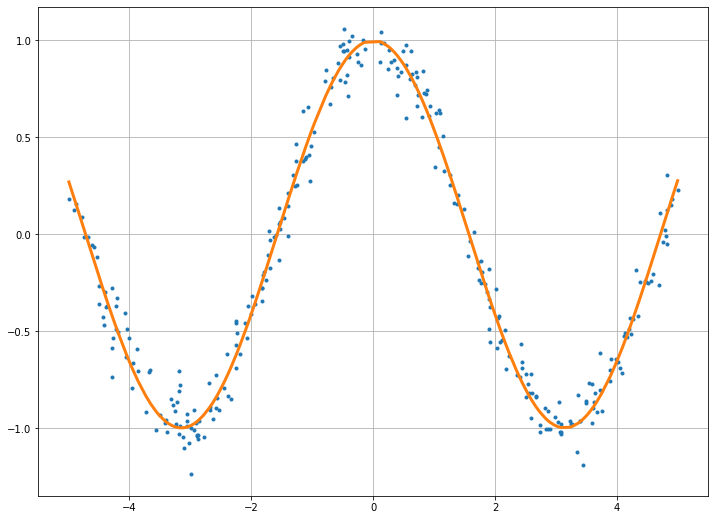

In [38]:
plt.plot(x, y, '.');
plt.plot(x, f(x), '-', lw=3)
plt.grid()

Т.к. у нас задача регрессии, то мы выберем в качестве функции потерь

$$
L(y, f) = \frac{1}{2}(y - f)^2
\\
\nabla L = - (y - f)
$$

В качестве базовой модели, возьмем деревья с глубиной 2.

Нулевое приближение

$$
\alpha_0 = \arg\min_\alpha \sum_n L(y_n , \alpha) = \arg\min_\alpha \sum_n (y_n - \alpha)^2
$$

$$
\alpha_0 = \frac{1}{N} \sum_n y_n 
$$

Псевдоостатки

$$
r_{nm} = - (y_n - R_{m-1}(\vec{x}_n))
$$

Поиск $\alpha_m$

$$
\alpha_m = \arg\min_{\alpha} \frac{1}{2}\sum_{n=1}^{N} (y_n - R_{m-1}(\vec{x_i}) - \alpha f_m(\vec{x}_n))^2
$$

$$
\alpha_m = \frac{\sum_n f_m(\vec{x}_n) (y_n - R_{m-1}(\vec{x}_n))}{\sum_n f_m^2(\vec{x}_n)}
$$

In [40]:
clfs = []
alphas = []
errors = []
alpha0 = y.mean()

In [41]:
def boost(X, alpha0, alphas, clfs):
    result = np.zeros(X.shape[0])
    result[:] = alpha0
    for a, clf in zip(alphas, clfs):
        result += a*clf.predict(X.reshape((-1, 1)))
    return result

In [42]:
def L(Y, Ypred):
    return 0.5 * (Y - Ypred)**2

def dL(Y, Ypred):
    return -(Y - Ypred)

In [43]:
from sklearn.tree import DecisionTreeRegressor

def boost_step(x, y, alpha0, alphas, clfs, plot=False):
    # Наша оценка на имеющихся моделях
    yc = boost(x, alpha0, alphas, clfs)
    # Псевдоостатки
    r = - dL(y, yc)
    # Обучаем модель и делаем предсказание
    clf = DecisionTreeRegressor(max_depth=2).fit(x.reshape((-1, 1)), r)
    pred = clf.predict(x.reshape((-1, 1)))
    # Находим альфу
    top = ( (y - yc) * pred ).sum()
    bottom = (pred * pred).sum()
    alpha = top / bottom
    
    alphas.append(alpha)
    clfs.append(clf)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.title("Step #%d" % len(alphas))
        plt.subplot(121)
        plt.grid()
        plt.title("Step #%d, MSE = %.4f" % (len(alphas), L(y, yc).mean()))
        plt.plot(x, y, '.')
        plt.plot(x, yc, '-', lw="3")
        
        plt.subplot(122)
        plt.title("Residuals")
        plt.plot(x, r, '.')
        plt.plot(x, pred, '-')
        plt.grid()
        plt.show()

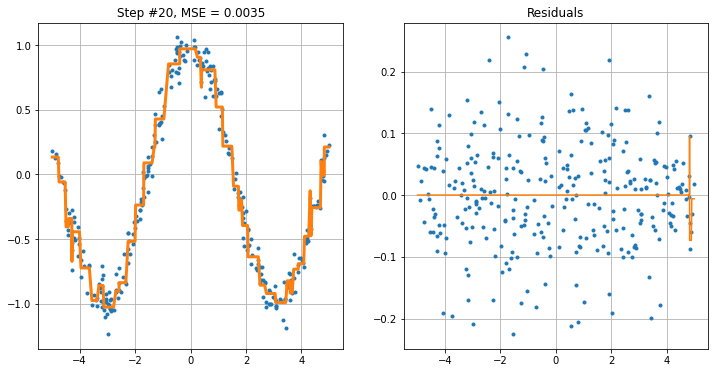

In [63]:
boost_step(x, y, alpha0, alphas, clfs, True)

In [36]:
f = lambda x: np.cos(x)
x = np.random.uniform(-5, 5, 300)
x.sort()
y = f(x) + np.random.normal(0, 0.2, x.shape)

x_test = np.random.uniform(-5, 5, 1000)
x_test.sort()
y_test = f(x_test) + np.random.normal(0, 0.2, x_test.shape[0])

clfs = []
alphas = []
errors = []
alpha0 = y.mean()

In [143]:
errors = []
errors_test = []
for _ in range(500):
    yp = boost(x, alpha0, alphas, clfs)
    errors.append(L(y, yp).mean())
    
    yp = boost(x_test, alpha0, alphas, clfs)
    errors_test.append(L(y_test, yp).mean())
        
    boost_step(x, y, alpha0, alphas, clfs, False)

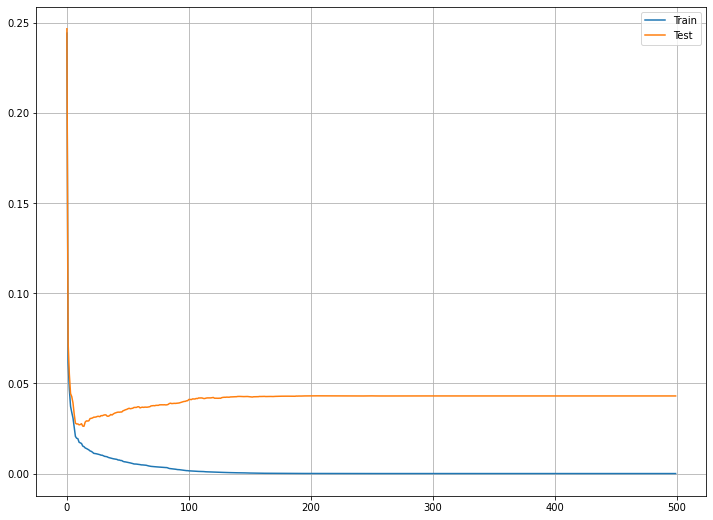

In [144]:
plt.plot(errors, '-', label='Train')
plt.plot(errors_test, '-', label='Test')
plt.legend()
plt.grid()
plt.show()

## sklearn

В библиотеке **sklearn** данный алгоритм реализован с помощью деревьев решений в двух классах __GradientBoostingClassifier__ и __GradientBoostingRegressor__ с довольно большим количеством гиперпараметров.

In [145]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_digits

X, Y = load_digits(return_X_y=True)
gbm = GradientBoostingClassifier(
    loss='deviance', 
    learning_rate=0.1,
    n_estimators=200)

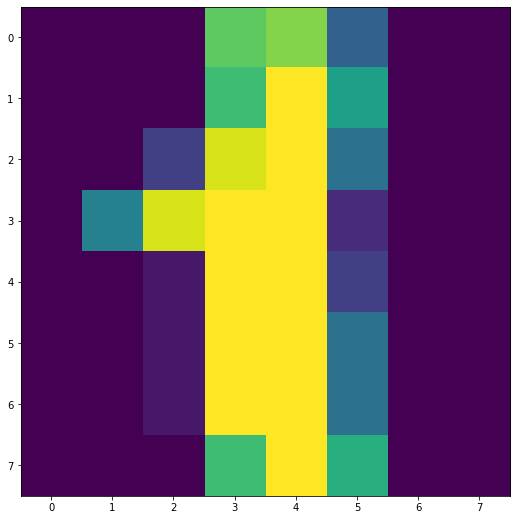

In [146]:
plt.imshow(X[1].reshape((8, 8)));

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

In [148]:
from sklearn.metrics import accuracy_score
 
gbm.fit(X_train, Y_train)
predict = gbm.predict(X_test)
accuracy_score(Y_test, predict)

0.9685185185185186

## Плюсы GBM

* один из наиболее мощных алгоритмов распознования
* если использовать в качестве базовой модели решающее дерево, то не очень чувствителен к масштабу данных
* множество способов улучшить алгоритм
* общий подход к решению задачи
* подходит по регрессию, классификацию и ранжирование
* можно использовать произвольную функцию потерь (зависит от поставленной задачи)
* есть очень хорошие готовые решения

## Минусы

* довольно трудоемкий алгоритм, если использовать много базовых моделей
* в "чистой" реализации очень склонен к переобучению
* не подходит для использования со сложными или сильными моделями
* иногда довольно сложная настройка
* неинтерпретируем

## Готовые решения

Одной из самых простых и быстрых моделей является - дерево решений. На основе деревьев реализованы очень мощные библиотеки:
* __[XGBoost](https://xgboost.ai/)__
* __[LightGBM](https://github.com/Microsoft/LightGBM)__
* __[CatBoost](https://catboost.ai/)__

Отдельно стоит отметить __[H2O](https://www.h2o.ai/)__

In [56]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=1000)

clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
accuracy_score(Y_test, predict)

0.9777777777777777

In [57]:
import lightgbm as lgbm

clf = lgbm.LGBMClassifier(max_depth=3, learning_rate=0.2, n_estimators=1000)

clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
accuracy_score(Y_test, predict)

0.9777777777777777

In [58]:
import catboost as cbgm

clf = cbgm.CatBoostClassifier(max_depth=3, n_estimators=1000,   verbose=False)

clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
accuracy_score(Y_test, predict)

0.9814814814814815

In [51]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, Y_train)
predict = clf.predict(X_test)
accuracy_score(Y_test, predict)

0.9888888888888889